2.1

In [77]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal

data = pd.read_csv('data.csv')
data = data.drop('Index', axis=1)
data = data.to_numpy()

def standardize(data):
    data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
    return data

data = standardize(data)  
print(data.shape)
epochs = 0

(2000, 7)


GMM Class

In [167]:
class GMM:
    def __init__(self, k, data):
        self.data = data
        self.k = k
        self.mean_list = []
        self.covariance_list = []
        self.distribution_list = []
        self.gaussian_list = []
        self.responsibility_list = np.zeros((self.k, self.data.shape[0]))
        self.gaussian_new_list = []
        self.loss_prev = 0
        self.loss_new = 0
        self.epochs = 0

    def initialise(self):
        self.mean_list = np.random.rand(self.k, self.data.shape[1])
        self.distribution_list = np.random.rand(self.k)
        
        for i in range(self.k):
            self.covariance_list.append(np.cov(self.data, rowvar=False))
            self.gaussian_list.append(multivariate_normal.pdf(self.data, mean=self.mean_list[i], cov=self.covariance_list[i], allow_singular=True))
        
    def expectation(self):
        sum = 0
        for i in range(self.k):
            sum += self.distribution_list[i] * self.gaussian_list[i]
        
        for i in range(self.k):
            self.responsibility_list[i] = (self.distribution_list[i] * self.gaussian_list[i]) / sum
    
    def maximization(self):
        m_c = np.sum(self.responsibility_list, axis=1)
        self.distribution_list = m_c / self.data.shape[0]
        self.mean_list = np.dot(self.responsibility_list, self.data) / m_c.reshape(-1, 1)
        
        for i in range(self.k):
            self.covariance_list[i] = (np.dot(self.responsibility_list[i] * (self.data - self.mean_list[i]).T, (self.data - self.mean_list[i])) / m_c[i]) + 1e-6 * np.eye(self.data.shape[1])

    def log_likelihood(self):     
        sum = 0
        for i in range(self.k):
            sum += self.distribution_list[i] * self.gaussian_new_list[i]   
        self.loss_new = np.sum(np.log(sum))
        #print(self.loss_new)
        
    def fit(self):
        self.epochs += 1
        self.expectation()
        self.maximization()
        self.gaussian_new_list = []

        for i in range(self.k):
            self.gaussian_new_list.append(multivariate_normal.pdf(self.data, mean=self.mean_list[i], cov=self.covariance_list[i], allow_singular=True))

        self.gaussian_new_list = np.array(self.gaussian_new_list)
        self.log_likelihood()

        while abs(self.loss_new - self.loss_prev) > 0.0001:
            self.loss_prev = self.loss_new
            self.gaussian_list = self.gaussian_new_list.copy()
            self.fit()

    def params(self):
        print(self.mean_list, self.covariance_list, self.distribution_list)

    def aic(self):
        d = 2
        paramaters = self.k * (d + d * d + 1)
        return -2 * self.loss_new + paramaters * 2
    
    def bic(self):
        d = 2
        paramaters = self.k * (d + d * d + 1)
        return -2 * self.loss_new + paramaters * np.log(self.data.shape[0])

In [126]:
gmm = GMM(3, data)
gmm.initialise()
gmm.fit()
#gmm.params()
print(gmm.epochs)

-16640.059641116517
-16486.14019573944
-16245.240968598016
-14904.239658323113
-15998.760421151885
-15876.883045980228
-15659.646152465024
-15390.689954069187
-15152.022421378319
-14906.870498701272
-15526.635229732054
-15484.641035835422
-15421.747737338974
-15355.780421847016
-15253.529143752865
-15047.92361816515
-14166.785661683905
-9468.211193210822
-14364.320993556303
-14362.858427215597
-14361.996300166122
-14361.453222876164
-14361.093563563505
-14360.845812986983
-14360.669685864294
-14360.541240627099
-14360.44560178565
-14360.373170768864
-14360.3175483228
-14360.27434467692
-14360.24047220889
-14360.213710979055
-14360.192433974626
-14360.175428697406
-14360.161778462356
-14360.150781626122
-14360.14189546571
-14360.134696423367
-14360.128851439904
-14360.124096946181
-14360.12022324053
-14360.117062719295
-14360.114480907843
-14360.112369556922
-14360.110641282396
-14360.109225372024
-14360.108064484051
-14360.107112033516
-14360.106330113196
-14360.105687833082
-14360.105

WINE-DATASET

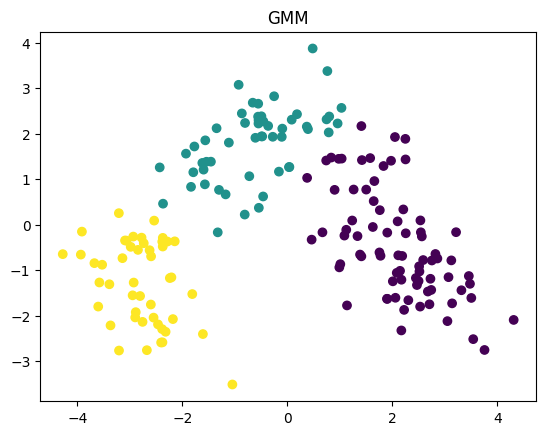

aic =  10
bic =  3


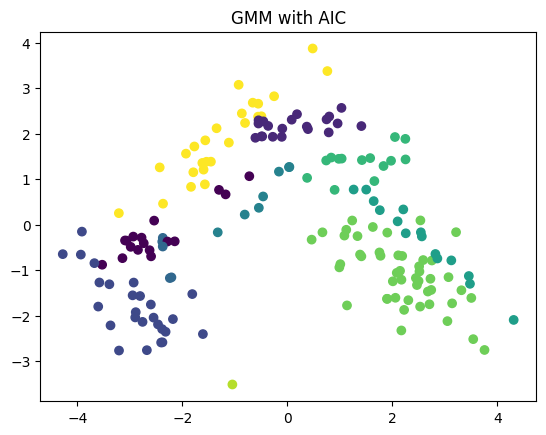

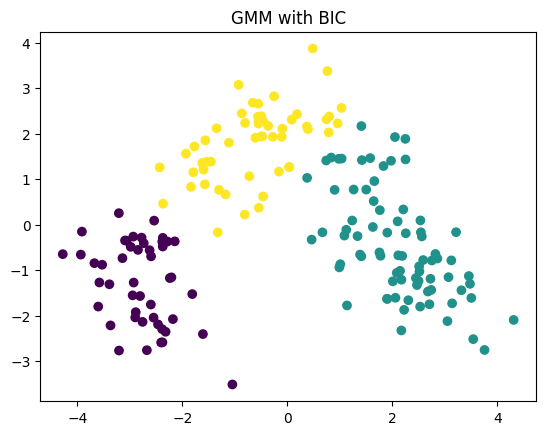

In [179]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

dataset = load_wine().data
Scaled_data = standardize(dataset)
 
principal = PCA(n_components=2)
principal.fit(Scaled_data)
x = principal.transform(Scaled_data)
pca1 = x[:, 0]
pca2 = x[:, 1]

gmm = GMM(3, x)
gmm.initialise()
gmm.fit()
plt.title("GMM")
plt.scatter(pca1, pca2, c=gmm.responsibility_list.argmax(axis=0))
plt.show()

d = 2
AIC = []
BIC = []

for k in range(1, 12):
    gmm_k = GMM(k, x)
    gmm_k.initialise()
    gmm_k.fit()

    AIC.append(gmm_k.aic())
    BIC.append(gmm_k.bic())

a = AIC.index(min(AIC)) + 1
b = BIC.index(min(BIC)) + 1

print("aic = ", a)
print("bic = ", b)

gmm_1 = GMM(a, x)
gmm_1.initialise()
gmm_1.fit()
plt.title("GMM with AIC")
plt.scatter(pca1, pca2, c=gmm_1.responsibility_list.argmax(axis=0))
plt.show()

gmm_2 = GMM(b, x)
gmm_2.initialise()
gmm_2.fit()
plt.title("GMM with BIC")
plt.scatter(pca1, pca2, c=gmm_2.responsibility_list.argmax(axis=0))
plt.show()

K-Means

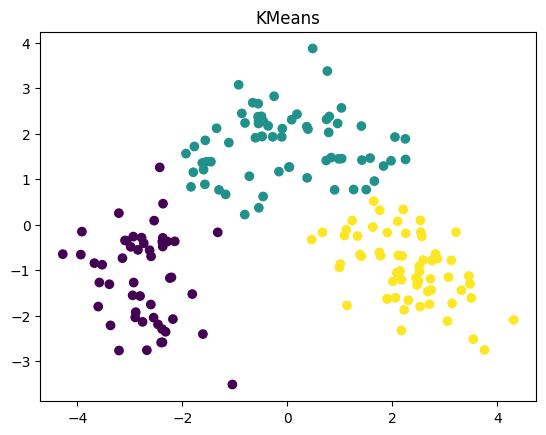

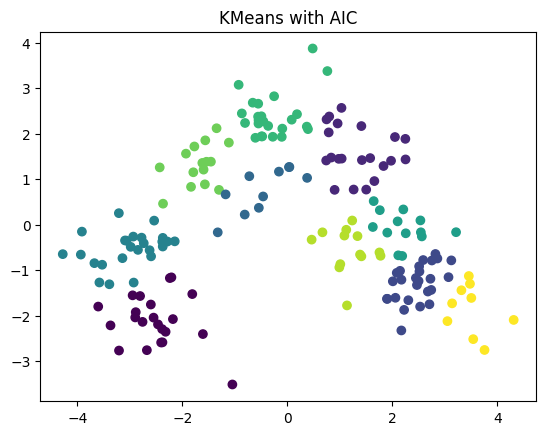

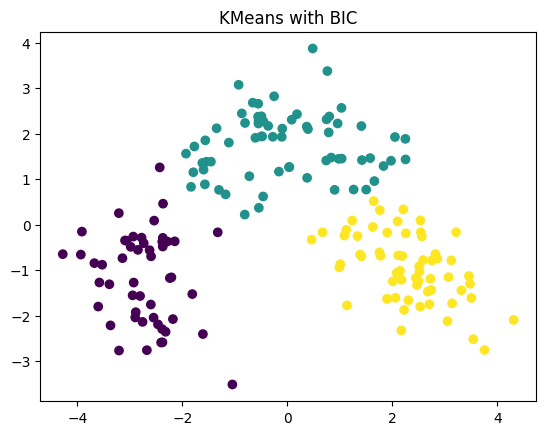

In [181]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(x)
plt.title("KMeans")
plt.scatter(pca1, pca2, c=kmeans.labels_)
plt.show()

kmeans_1 = KMeans(n_clusters=a, random_state=0, n_init="auto").fit(x)
plt.title("KMeans with AIC")
plt.scatter(pca1, pca2, c=kmeans_1.labels_)
plt.show()

kmeans_2 = KMeans(n_clusters=b, random_state=0, n_init="auto").fit(x)
plt.title("KMeans with BIC")
plt.scatter(pca1, pca2, c=kmeans_2.labels_)
plt.show()

Silhouette scores

In [178]:
from sklearn.metrics import silhouette_score

score = silhouette_score(x, kmeans_1.labels_)
print("Silhouette Score for KMeans with AIC = ", score)

score = silhouette_score(x, kmeans_2.labels_)
print("Silhouette Score for KMeans with BIC = ", score)

score = silhouette_score(x, gmm_1.responsibility_list.argmax(axis=0))
print("Silhouette Score for GMM with AIC = ", score)

score = silhouette_score(x, gmm_2.responsibility_list.argmax(axis=0))
print("Silhouette Score for GMM with BIC = ", score)

Silhouette Score for KMeans with AIC =  0.4114349023607514
Silhouette Score for KMeans with BIC =  0.5601697480957203
Silhouette Score for GMM with AIC =  0.18942995085854192
Silhouette Score for GMM with BIC =  0.5319722918135585


- KMeans vs. GMM Graphs Comparison:
  - GMM displays clusters with varying sizes and shapes, while KMeans shows clusters that are uniformly spherical.
  - KMeans outperforms GMM with a higher Silhouette score, indicating its superior clustering performance.
  - GMM exhibits less distinct cluster boundaries, while KMeans presents well-defined and clear cluster boundaries.